# <b><u>0) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u></b>

In [1]:
# Booléen qui active l'installation des modules/librairies qui sont
# nécessaires au bon fonctionnement de ce Notebook (cf section 1.1).
installation = False
# Chemin de données (en local) vers le répertoire de rangement de
# la base de donnée initiale (cf section 2 du Notebook).
abs_path_p4 = "C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P4/"
abs_path_b2d = abs_path_p4 + "B2D/"
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_figure = False
abs_path_fig = abs_path_p4 + "Figures/Stabilite/"
prefixe_titre_fig = abs_path_fig + "_V3_sansTSNEavecSample_P01A_T1W_"

# 
# <b><u>I) Installations et importations des libriaries/modules python utiles pour ce Notebbok.</u></b>
 
## <b><u>I.1) Installation (sautez cette étape si vous les avez déjà sur votre ordinateur).</u></b>

In [2]:
# Installation conditionnée au booléen précédent
if installation:
    ! pip install numpy
    ! pip install pandas
    ! pip install matplotlib
    ! pip install seaborn
    ! pip install datetime
    ! pip install sklearn


## <b><u>I.2) Importations.</u></b>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime

### Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import adjusted_rand_score as ari_score

## <b><u>I.3) Définitions de fonctions personnelles.</u></b>

In [4]:
rgn = 420  # np.random.RandomState(420)

In [5]:
def identity(tab):
    """Retourne en sortie l entree de la fonction."""
    return tab

In [6]:
def groupby_seg_rfm_6feat(
    df_input=pd.DataFrame([0]),
    p_temp=[pd.to_datetime("2000-01-15"), pd.to_datetime("2022-04-10")],
):
    """Calcule les 6 features de la segmentation RFM augmentée présentée
    dans le notebook précédent, à partir d'un dataframe, et en faisant 
    une sélection supplémentaire des éléments qui se trouve au sein 
    d'une fenêtre temporelle définie en entrée de cette fonction.

    Arguments de cette fonction :
    df_input -- dataset d'entrée qui doit contenir au moins les 6 
    colonnes habituelle rappelée dans les 1ères lignes de cette fonction
    (par défaut pd.DataFrame([0]))
    p_temp -- fenêtre temporelle servant à la sélection supplémentaire, 
    définie comme une liste de deux dates, les bornes inférieures et 
    supérieures de cette fenêtre temporelle (par défaut 
    [pd.to_datetime("2000-01-15"), pd.to_datetime("2022-04-10")])"""
    col_date = "order_purchase_timestamp"
    col_client = "customer_unique_id"
    col_montant = "payment_value"
    col_score = "review_score"
    col_lenght = "review_lenght_comment_message"
    col_statut = "order_status_delivered"
    list_indx = (
        df_input.where(
            np.logical_and(
                df_input[col_date] >= p_temp[0], df_input[col_date] < p_temp[1]
            )
        )
        .dropna(axis=0, how="all")
        .index
    )
    tab_clients = df_input.loc[list_indx, col_client].unique()
    df_groupby = df_input.loc[list_indx].groupby(col_client)
    recence = (
        df_groupby[col_date]
        .max()
        .apply(lambda date: (p_temp[1] - date).days)
        .loc[tab_clients]
        .values
    )
    df_output = pd.DataFrame(data=recence, columns=["R"], index=tab_clients)
    df_output["F"] = (
        df_input.loc[list_indx, col_client].value_counts().loc[tab_clients].values
    )
    df_output["M"] = df_groupby[col_montant].mean().loc[tab_clients].values
    df_output["Score_m"] = df_groupby[col_score].mean().loc[tab_clients].values
    df_output["Lenght_m"] = df_groupby[col_lenght].mean().loc[tab_clients].values
    df_output["Bool_Delv_m"] = df_groupby[col_statut].mean().loc[tab_clients].values
    del (
        recence,
        list_indx,
        df_groupby,
        tab_clients,
        col_date,
        col_client,
        col_montant,
        col_score,
        col_lenght,
        col_statut,
    )
    return df_output

In [7]:
def scaling_6feat(
    df_input=pd.DataFrame(data=np.ones(6)),
    operation="fit_transform",
    tab_pipeline=[make_pipeline(FunctionTransformer(identity))],
):
    """Réalise le feature scaling des 6 features de la RFM augmentée.

    Arguments de cette fonction :
    df_input -- dataset d'entrée qui doit contenir au moins les 6 
    colonnes habituelle rappelée dans les 1ères lignes de cette fonction
    (par défaut pd.DataFrame([0]))
    operation -- chaîne de carctère, qui vaut soit fit_transform (si on
    applqiue ce scaling pour la première fois) ou transform (si on veut
    appliquer un scaling déjà entraîné sur un autre jeu de donnée, par 
    exemple pour prédire les cluster d'appartenace d'une nouvelle 
    fenêtre temporelle à partir d'un modèle entraîné sur la fenêtre 
    temporelle initiale)(par défaut fit_transform)
    tab_pipeline -- liste de pipeline des opérations successives de feature scaling
    (par défaut [make_pipeline(FunctionTransformer(identity))])"""
    if operation == "fit_transform":
        tab_pipeline_a_fiter = tab_pipeline
        df_output = pd.DataFrame(
            data=np.array(
                [
                    tab_pipeline_a_fiter[i].fit_transform(
                        X=df_input[df_input.columns[i]].values.reshape(-1, 1)
                    )
                    for i in range(len(tab_pipeline_a_fiter))
                ]
            ).T.reshape(-1, len(tab_pipeline_a_fiter)),
            index=df_input.index,
            columns=df_input.columns,
        )
        tab_pipeline_fitee = tab_pipeline_a_fiter
        del tab_pipeline_a_fiter
        return df_output, tab_pipeline_fitee
    elif operation == "transform":
        df_output = pd.DataFrame(
            data=np.array(
                [
                    tab_pipeline[i].transform(
                        X=df_input[df_input.columns[i]].values.reshape(-1, 1)
                    )
                    for i in range(len(tab_pipeline))
                ]
            ).T.reshape(-1, len(tab_pipeline)),
            index=df_input.index,
            columns=df_input.columns,
        )
        return df_output

In [8]:
def predict_from_k0vsfit_predict_from_kn(
    df_input_n, p_temp_n, tab_pipeline_0, tab_pipeline_n, k_0, k_n
):
    """Réalise les prédictions sur la fenêtre temporelle n°N, à partir
    du modèle entraîné sur cette fenêtre (noté k_n) et du modèle entraîné 
    sur la fenêtre temporelle n°0 initialle (noté k_0). Réalise pour celà,
    et en interne, des appels à toutes les autres fonctions définies 
    précédemment.

    Arguments de cette fonction :
    df_input_n -- dataset d'entrée 
    p_temp_n -- fenêtre temporelle n°N, servant à la sélection 
    supplémentaire, définie comme une liste de deux dates, les bornes 
    inférieures et supérieures de cette fenêtre temporelle 
    tab_pipeline_0 -- liste de pipeline des opérations successives de 
    feature scaling déjà entraînées sur la fenêtre initiale n°0
    tab_pipeline_n -- liste de pipeline des nouvelles opérations 
    successives de feature scaling qu'on veut entraîner sur la nouvelle
    fenêtre temporelle n°N
    k_0 -- modèle de clustering déjà entraîné sur la fenêtre temporelle
    initiale n°0
    k_n -- nouveaux modèle de clustering qu'on veut entraîner sur la 
    nouvelle fenêtre temporelle n°N"""
    ### Création des 6 features pour Segmentation RFM augmentée
    df_pn = groupby_seg_rfm_6feat(df_input=df_input_n, p_temp=p_temp_n)
    ### Features scaling
    # à partir de la pipeline entraînée sur P0
    df_pn_scaled0 = scaling_6feat(
        df_input=df_pn, operation="transform", tab_pipeline=tab_pipeline_0
    )
    # à partir d'une pipeline neuve entraînée sur PN
    df_pn_scaled, tab_pipeline_n_fitee = scaling_6feat(
        df_input=df_pn, operation="fit_transform", tab_pipeline=tab_pipeline_n
    )
    ### Prédictions des clusters
    # à partir de l'algo entraîné sur P0
    labels_pn_k0 = k_0.predict(df_pn_scaled0)
    # à partir d'un algo neuf entraîné sur PN
    labels_pn_kn = k_n.fit_predict(df_pn_scaled)
    return labels_pn_k0, labels_pn_kn

### Fonctions graphiques à partir d'ici.

In [9]:
def pairplot_clusters(titre, algo, df_input_scaled, df_input):
    """Affiche la éléments dans deux espaces de features, avec code 
    couleur selon le cluster d'appartenance. A recours à la fonction
    seaborn.pairplot

    Arguments de cette fonction :
    titre -- titre de la figure
    algo -- modèle de clusetring, déjà entraîné
    df_input_n_scaled -- dataset d'entrée, représente un type d'espace
    de features (pas nécessairement après scaling)
    df_input_n -- dataset d'entrée, représente un autre type d'espace
    de features"""
    X_scaled, X = df_input_scaled.copy(deep=True), df_input.copy(deep=True)
    plt.figure(titre, figsize=(24, 12)), plt.clf()
    ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)
    cluster_labels, n_clusters = algo.labels_, algo.n_clusters
    X_scaled["numC"], X["numC"] = cluster_labels, cluster_labels
    dic_color = {i: cm.nipy_spectral(float(i) / n_clusters) for i in range(n_clusters)}
    ### 1st Plot showing the clusters formed in features scaled space
    sns.pairplot(
        X_scaled,
        corner=True,
        diag_kws={"log_scale": (False, True), "fill": False},
        diag_kind="hist",
        hue="numC",
        palette=dic_color,
    )
    plt.savefig(abs_path_fig + "curent_pairplot.png"), plt.close(), X_scaled.drop(
        columns=["numC"], inplace=True
    )
    ax1.imshow(plt.imread(abs_path_fig + "curent_pairplot.png")), ax1.set_yticks(
        ticks=[]
    ), ax1.set_xticks(ticks=[])
    ax1.set_title(
        titre + " - Espace RFM augmenté, features scaling",
        fontdict={"fontsize": 15, "fontweight": "bold"},
    )
    ### 2nd Plot showing the actual clusters formed
    sns.pairplot(
        X,
        corner=True,
        diag_kws={"log_scale": (False, True), "fill": False},
        diag_kind="hist",
        hue="numC",
        palette=dic_color,
    )
    plt.savefig(abs_path_fig + "curent_pairplot.png"), plt.close(), X.drop(
        columns=["numC"], inplace=True
    )
    ax2.imshow(plt.imread(abs_path_fig + "curent_pairplot.png")), ax2.set_yticks(
        ticks=[]
    ), ax2.set_xticks(ticks=[])
    ax2.set_title(
        titre + " - Espace RFM augmenté",
        fontdict={"fontsize": 15, "fontweight": "bold"},
    )
    ### On ressere les deux sous figures
    plt.tight_layout()
    if sauvegarde_figure:
        plt.savefig(prefixe_titre_fig + titre + ".png")
    del X_scaled, X, ax1, ax2, dic_color, n_clusters, cluster_labels

# 
# <b><u>II) Base de donnée de travail.</u></b>
## 
## <b><u>II.1) Chargement de la B2D élaborée préalablement.</u></b>
## La base de données correspondante a été stockée en local. 

In [10]:
# chargement effectif
df_b2d_rfm = pd.read_csv(abs_path_b2d + "B2D_RFM.csv").drop(columns=["Unnamed: 0"])
# affichage
df_b2d_rfm

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_message,review_lenght_comment_message
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,credit_card,2,146.87,4,NaN,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,credit_card,8,335.48,5,NaN,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,credit_card,7,157.73,5,NaN,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,credit_card,1,173.30,5,NaN,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,credit_card,8,252.25,5,O baratheon è esxelente Amo adoro o baratheon,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103664,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,1,credit_card,6,88.78,4,NaN,0
103665,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,1,credit_card,3,129.06,5,NaN,0
103666,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,1,credit_card,5,56.04,1,Esperava qualidade no atendimento e estou tend...,68
103667,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,1,credit_card,2,711.07,5,NaN,0


## 
## <b><u>II.2) Travail préparatoire pour la segmentation RFM à venir.</u></b>
### <b><u>II.2.a) Réduction de dimension : suppression des colonnes inutiles.</u></b>
### On ne garde que les colonnes suivantes pour la segmentation RFM :
#### - <i>customer_unique_id</i> ;
#### - <i>order_purchase_timestamp</i> ;
#### - <i>payment_value</i>.
### Par ailleurs, on garde également celles-ci, comme expliqué dans le notebook précédent.
#### - <i>order_status</i> ;
#### - <i>review_score</i> ;
#### - <i>review_lenght_comment_message</i>.

In [11]:
### Definition des colonnes à conserver/a supprimer.
# Liste des colonnes à conserver.
colonnes = [
    "customer_unique_id",
    "order_purchase_timestamp",
    "payment_value",
    "order_status",
    "review_score",
    "review_lenght_comment_message",
]
# Liste des colonnes à supprimer.
col_a_sup = [col for col in df_b2d_rfm.columns if col not in colonnes]
### Suppression effective.
df_b2d_rfm.drop(columns=col_a_sup, inplace=True)
# Suppression des variables devenues inutiles
del colonnes, col_a_sup
# Affichage de contrôle
print(f"Il reste {df_b2d_rfm.shape[1]} colonnes dans la B2D")

Il reste 6 colonnes dans la B2D


## 
### <b><u>II.2.b) <i>Features engineering</i> : reformatages de certaines colonnes.</u></b>
### Comme dans le notebook précédent :
#### - on va utiliser le <i>one hot encoding</i> pour transformer en une colonne de booléen le paramètre <i>order_status</i> ;
#### - on va reformater <i>order_purchase_timestamp</i> pour en faire un objet interprètable en tant que date.

In [12]:
### One hot encoder la colonne order_status
# Param original, futur nouveau param
col_i, col_f = "order_status", "order_status_delivered"
# Entraînement du One Hot Encoder
ohenc = OneHotEncoder().fit(df_b2d_rfm[col_i].values.reshape(-1, 1))
# Production de la matrice de booléens correspondante
mat = ohenc.transform(df_b2d_rfm[col_i].values.reshape(-1, 1)).toarray()
# Création du nouveau paramètre booléen de la B2D
df_b2d_rfm[col_f] = mat[:, list(ohenc.get_feature_names([col_i])).index(col_f)]
# Suppression de l'ancien paramètre string
df_b2d_rfm.drop(columns=[col_i], inplace=True)
# Suppression des variables devenues inutiles
del col_i, col_f, ohenc, mat
### Transformer la colonne order_purchase_timestamp en colonne de dates
# Paramètre visé
col = "order_purchase_timestamp"
# Transformation en objets de type datetime
df_b2d_rfm[col] = pd.to_datetime(df_b2d_rfm[col])
# Suppression des variables devenues inutiles
del col
### Affichage de contrôle
df_b2d_rfm

,customer_unique_id,order_purchase_timestamp,payment_value,review_score,review_lenght_comment_message,order_status_delivered
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87,4,0,1.0
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48,5,0,1.0
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,157.73,5,0,1.0
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,173.30,5,0,1.0
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,252.25,5,45,1.0
...,...,...,...,...,...,...
103664,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,88.78,4,0,1.0
103665,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,129.06,5,0,1.0
103666,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,56.04,1,68,1.0
103667,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,711.07,5,0,1.0


## 
### <b><u>II.2.b) Réduction de dimension : suppression des éléments dupliqués.</u></b>
### Comme dans le notebook précédent, on va chercher dans cette B2D si des mêmes séries de valeurs sont prises pour les 6 colonnes, entre au moins deux lignes différentes. Et si c'est le cas, on supprimera les lignes correspondantes.

In [13]:
# Colonnes surlesquelles on avait fait la suppression
subset = ["customer_unique_id", "order_purchase_timestamp", "payment_value"]
# Recherche d'éventuels éléments dupliqués.
if df_b2d_rfm.duplicated(subset=subset).sum() >= 1:
    print(
        f"Il y a {df_b2d_rfm.duplicated(subset=subset).sum()} lignes dupliquées pour le subset original, soit {100*df_b2d_rfm.duplicated(subset=subset).sum()/df_b2d_rfm.shape[0] : >4.1f}% des lignes de la B2D"
    )
    # Suppression effective le cas échéant
    df_b2d_rfm.drop_duplicates(subset=subset, inplace=True)
# Affichage de contrôle
print(
    f"Après suppression des éléments dupliqués, il reste {df_b2d_rfm.shape[0]} lignes dans la B2D."
)

Il y a 1244 lignes dupliquées pour le subset original, soit  1.2% des lignes de la B2D
Après suppression des éléments dupliqués, il reste 102425 lignes dans la B2D.


# 
# <b><u>III) Modèle de référence.</u></b>
### 
### <u>RAPPEL :</u>
### Le modèle de référence, établit lors du notebook précédent, est le suivant :
#### 1) faire une segmentation RFM "augmentée" des 3 <i>features</i> complémentaires (relatifs à la satisfaction du client - longueur de message, note- et au statut de la commande - livrée ou pas) ;
#### 2) <i>features scaling</i>, de sorte à égaliser les variances de ces 6 paramètres ;
#### 4) application d'un KMeans() à 6 clusters.

### 
## <u><b>III.1) Procédé général :</b></u>
### 
### <u><b>III.1.a) Description de l'algorithme:</b></u>
### (0) On va appliquer ce modèle sur une fenêtre temporelle "P0" de référence, d'une durée "D0". Pour être sûr qu'elle contienne assez de données (en particulier, concernant des clients récurents/non uniques), on prend une fenêtre de durée D0 = 1 an. Par exemple, P0 = [octobre 2016 ; octobre 2017].
### (0.bis) On prédit une apparetance à des clusters pour l'ensemble des clients de cette période P0, grâce à un modèle K0 entraîné sur P0. Ce qui définit une catégorisation de référence= {C0_1 ... C0_6}.
### (1) On fait augmente la borne supérieure de cette fenêtre d'une unité de temps de temps "T", de sorte que la nouvelle fenêtre temporelle "P1" contienne P0, avec une durée "D1" = D0+T. Par exemple, T = 1 mois.
### (1.bis) On fait une prédiction d'apparetenance aux clusters {C1_1 ... C1_6} pour tous les éléments de P1 grâce à un modèle vierge K1 re-entraîné sur P1, ainsi qu'une prédiction comparative grâce au modèle déjà entraîné sur P0 : {C01_1 ... C01_6}
### (1.ter) On applique l'ARI entre {C01_1 ... C01_6} et {C1_1 ... C1_6} pour les éléments communs à P0 et P1.
### (2) On décale de nouveau la borne supérieure la fenêtre d'un intervalle temporel T : P1 inclu dans P2, D2 = D0 + 2T.
### (2.bis) On fait une prédiction d'apparetenance aux clusters {C2_1 ... C2_6} pour tous les éléments de P2 grâce à un modèle vierge K2 re-entraîné sur P2, ainsi qu'une prédiction comparative grâce au modèle déjà entraîné sur P0 : {C02_1 ... C02_6}
### (2.ter) On appliquue l'ARI entre {C02_1 ... C02_6} et {C2_1 ... C2_6} pour les éléments communs à P1 et P2.
### (3) On réitère les 3 étapes précédentes jusqu'à obtenir une baisse sensible de l'ARI (sous 0.8).
### (4) On conclut quant à la durée pour laquelle il faut ré-entraîner le modèle.

### 
### <u><b>III.1.b) Quelques variables intérprétables comme des durées temporelles :</b></u>
### On crée ci-dessous des variables de durée D0 de la fenêtre temporelle initiale, et delta_T celle de décallage dans le temps de la borne supérieure de ces fenêtres.

In [14]:
# Respectivement : D0 et T
duree_0, delta_t = np.timedelta64(12, "M"), np.timedelta64(1, "W")

### 
## <u><b>III.2) Application sur les trois premières étapes : création de 6 clusters de référence.</b></u>
### 
### <u><b>III.2.a) Fenêtre temporelle intinale.</b></u>

In [15]:
# On définit notre borne temporelle inférieure
t0 = pd.to_datetime("2016-09-01")
# On en déduit notre période initiale P0 = t0 + D
p0 = [t0, t0 + duree_0]
# On construit un Dataframe correspondant à P0
df_p0 = groupby_seg_rfm_6feat(df_b2d_rfm, p0)
# Affichage de contrôle
df_p0

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
861eff4711a542e4b93843c6dd7febb0,107,1,146.87,4.0,0.0,1.0
e607ede0e63436308660236f5a52da5e,18,1,123.00,5.0,0.0,1.0
4390ddbb6276a66ff1736a6710205dca,139,1,94.63,5.0,21.0,1.0
2e6a42a9b5cbb0da62988694f18ee295,108,1,47.59,3.0,0.0,1.0
e079b18794454de9d2be5c12b4392294,78,2,218.89,5.0,14.5,1.0
...,...,...,...,...,...,...
1c137fe37df712015f6488edafe8ece4,218,1,64.42,1.0,41.0,1.0
206e64e8af2633a2ebe158a7fcb860db,108,1,102.03,1.0,0.0,1.0
874c93d867b18eb09a5e2f071ee89458,157,1,130.85,4.0,0.0,1.0
277490f0d435b602fe4475d4b89e9181,99,1,102.03,5.0,0.0,1.0


In [16]:
df_p0.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
count,22461.000000,22461.000000,22461.000000,22461.000000,22461.000000,22461.000000
mean,98.922132,1.082855,157.142897,4.128205,28.754927,0.956862
std,68.209483,0.501858,225.666884,1.300816,48.098813,0.201856
min,0.000000,1.000000,2.643636,1.000000,0.000000,0.000000
1%,1.000000,1.000000,19.944000,1.000000,0.000000,0.000000
5%,8.000000,1.000000,30.303333,1.000000,0.000000,1.000000
10%,16.000000,1.000000,37.620000,1.000000,0.000000,1.000000
25%,42.000000,1.000000,58.970000,4.000000,0.000000,1.000000
50%,91.000000,1.000000,100.820000,5.000000,0.000000,1.000000
75%,149.000000,1.000000,170.880000,5.000000,43.000000,1.000000


### 
### <u><b>III.2.b) <i>Features scaling</i> du Dataframe issu de P0.</b></u>
### On commence par créer un tableau de <i>pipelines</i> sur le modèle de ce qui a été rélaisé pour réaliser le <i>features scaling</i> des paramètres RFM augmentés dans le <i>notebook</i> précédent

In [17]:
# Première liste de transformateur, un par paramètre de P0
tab_fonct_trans = [
    FunctionTransformer(identity),
    FunctionTransformer(np.log1p),
    FunctionTransformer(np.log1p),
    FunctionTransformer(identity),
    FunctionTransformer(np.log1p),
    FunctionTransformer(identity),
]
# Seconde liste
tab_scaler = [
    QuantileTransformer(output_distribution="normal"),
    StandardScaler(),
    QuantileTransformer(output_distribution="normal"),
    StandardScaler(),
    StandardScaler(),
    StandardScaler(),
]
# Liste des pipelines, une par paramètre de P0
tab_pipeline = [make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)]

### On applique ce <i>gfeatures scaling</i> au Dataframe correspondant à P0 :

In [18]:
df_p0_scaled, tab_pipeline_p0 = scaling_6feat(df_p0, "fit_transform", tab_pipeline)
# Affichage
df_p0_scaled

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
861eff4711a542e4b93843c6dd7febb0,0.203379,-0.227539,0.476072,-0.098560,-0.828691,0.21371
e607ede0e63436308660236f5a52da5e,-1.212751,-0.227539,0.252311,0.670206,-0.828691,0.21371
4390ddbb6276a66ff1736a6710205dca,0.574595,-0.227539,-0.066541,0.670206,0.712639,0.21371
2e6a42a9b5cbb0da62988694f18ee295,0.220058,-0.227539,-0.952295,-0.867325,-0.828691,0.21371
e079b18794454de9d2be5c12b4392294,-0.172731,2.940516,0.957151,0.670206,0.538013,0.21371
...,...,...,...,...,...,...
1c137fe37df712015f6488edafe8ece4,1.851734,-0.227539,-0.558392,-2.404857,1.035076,0.21371
206e64e8af2633a2ebe158a7fcb860db,0.220058,-0.227539,0.018820,-2.404857,-0.828691,0.21371
874c93d867b18eb09a5e2f071ee89458,0.764710,-0.227539,0.332629,-0.098560,-0.828691,0.21371
277490f0d435b602fe4475d4b89e9181,0.090452,-0.227539,0.018820,0.670206,-0.828691,0.21371


### 
### <u><b>III.2.d) Clusterisation par KMeans().</b></u>

In [19]:
kmeans_p0 = KMeans(n_clusters=6, random_state=rgn)
kmeans_p0.fit(df_p0_scaled)

KMeans(n_clusters=6, random_state=420)

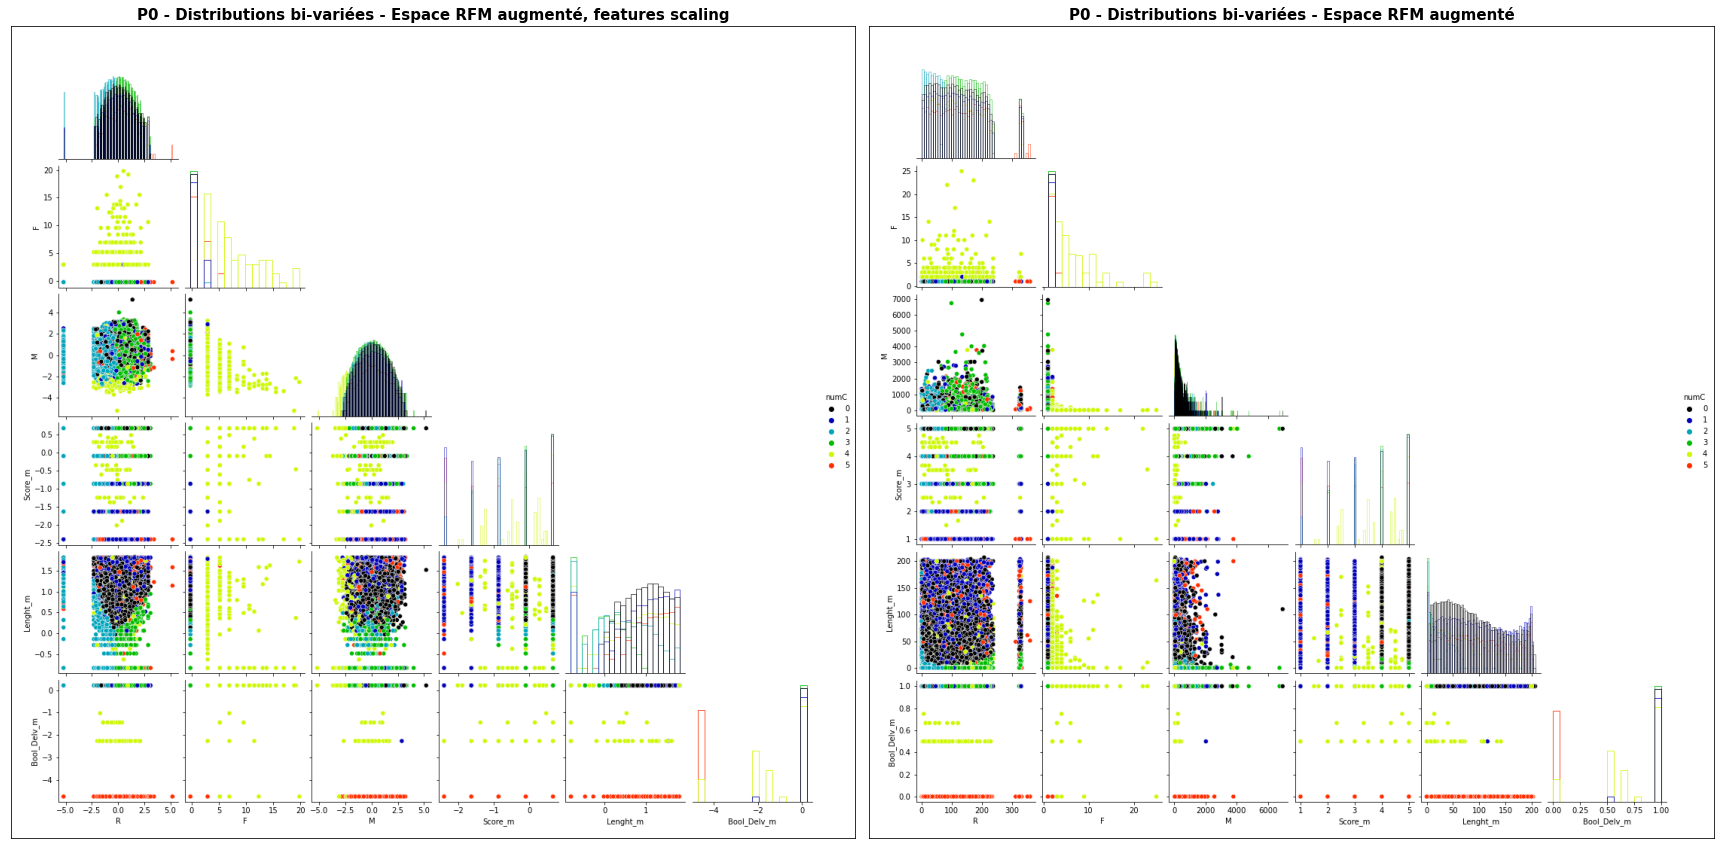

In [20]:
pairplot_clusters("P0 - Distributions bi-variées", kmeans_p0, df_p0_scaled, df_p0)

# 
# <b><u>IV) Calculs d'ARI :</u></b>
## <b><u>IV.1) Test de nos fonctions :</u></b>
### On met à l'essai nos fonction sur P1, qui ne possède que qulques éléments de plus que P0 (car il y a seulement un semaine de plus de P1 à P0, P0 représentant une année complète). On devrait donc avoir un ARI proche de 1 entre les prédictions sur P1 de K1 et de K0. 

In [21]:
### Création des 6 features RFM augmenté
df_p1 = groupby_seg_rfm_6feat(df_input=df_b2d_rfm, p_temp=[t0, t0 + duree_0 + delta_t])
### Création de la pipeline propre à P1 et scaling
tab_pipeline_p1 = [make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)]
df_p1_scaled, tab_pipeline_p1_fitee = scaling_6feat(
    df_input=df_p1, operation="fit_transform", tab_pipeline=tab_pipeline_p1
)
### Entraînement de K1 et prédictions sur P1
k_p1 = KMeans(n_clusters=kmeans_p0.get_params()["n_clusters"], random_state=rgn)
labels_p1_k1 = k_p1.fit_predict(df_p1_scaled)
### Scaling selon la pipelin de P0 pour préparer la prédiction de K0 sur P1
df_p1_scaled_k0 = scaling_6feat(
    df_input=df_p1, operation="transform", tab_pipeline=tab_pipeline_p0
)
### Puis prédiction de K0 sur P1
labels_p1_k0 = kmeans_p0.predict(df_p1_scaled_k0)
### Affichage de l'ARI
ari_score(labels_p1_k1, labels_p1_k0)

0.9427925382485802

### C'est un score assez élevé pour considéré que nos fonctions ont produit le résultat escompté.
### D'ailleurs, si on compare les clusters prédit par K1 et ceux par K0 :

In [22]:
df_p1["labels_k1"] = labels_p1_k1
df_p1["labels_k0"] = labels_p1_k0
df_p1_describe_k1 = df_p1.drop(columns=["labels_k0"]).groupby("labels_k1").describe()
df_p1_describe_k1[
    np.concatenate(
        (
            [("R", "count")],
            [(col, "mean") for col in df_p1_describe_k1.columns.levels[0]],
        )
    )
].sort_values(by=("R", "count"))

R                     F           M   Score_m   Lenght_m  \
            count        mean      mean        mean      mean       mean   
labels_k1                                                                  
0           962.0  130.133056  1.030146  202.741085  1.809771  63.369023   
3          1394.0   95.672166  2.368723   99.616013  4.188464  27.005966   
2          2836.0  108.490480  1.002116  176.807770  1.690409  80.922779   
4          5578.0  103.767121  1.000000  172.395798  4.779670  59.753137   
5          5859.0   37.289128  1.000512  142.064751  4.591569   1.090630   
1          6722.0  151.307349  1.000000  159.657883  4.542547   0.393930   

          Bool_Delv_m  
                 mean  
labels_k1              
0            0.000000  
3            0.980797  
2            0.999824  
4            1.000000  
5            1.000000  
1            1.000000

In [23]:
df_p1_describe_k0 = df_p1.drop(columns=["labels_k1"]).groupby("labels_k0").describe()
df_p1_describe_k0[
    np.concatenate(
        (
            [("R", "count")],
            [(col, "mean") for col in df_p1_describe_k0.columns.levels[0]],
        )
    )
].sort_values(by=("R", "count"))

R                     F           M   Score_m   Lenght_m  \
            count        mean      mean        mean      mean       mean   
labels_k0                                                                  
5           962.0  130.133056  1.030146  202.741085  1.809771  63.369023   
4          1392.0   95.687500  2.369253   99.470526  4.190889  27.013159   
1          2837.0  108.821290  1.002467  177.280717  1.688756  80.833627   
2          5541.0   34.192925  1.000722  142.805787  4.592853   1.509836   
0          5563.0  105.128348  1.000000  172.109684  4.779436  59.687039   
3          7056.0  147.280187  1.000000  158.354816  4.544926   0.304989   

          Bool_Delv_m  
                 mean  
labels_k0              
5            0.000000  
4            0.980769  
1            0.999824  
2            1.000000  
0            1.000000  
3            1.000000

### Le rangement des clusters par ordre croissant de nombre de client permet de confirmer que les 6 clusters sont quasimment identiques d'une prédiction à l'autre, en n'étant pas exactement dans le même ordre pour les clusters à ~5500 éléments. Pour résumer, chaque cluster prédit par K1 a son quasi jumeau prédit par K0.
### Ce que confirme cette affichage graphique (à gauche les prédictions de K1, à droite celles de K0)

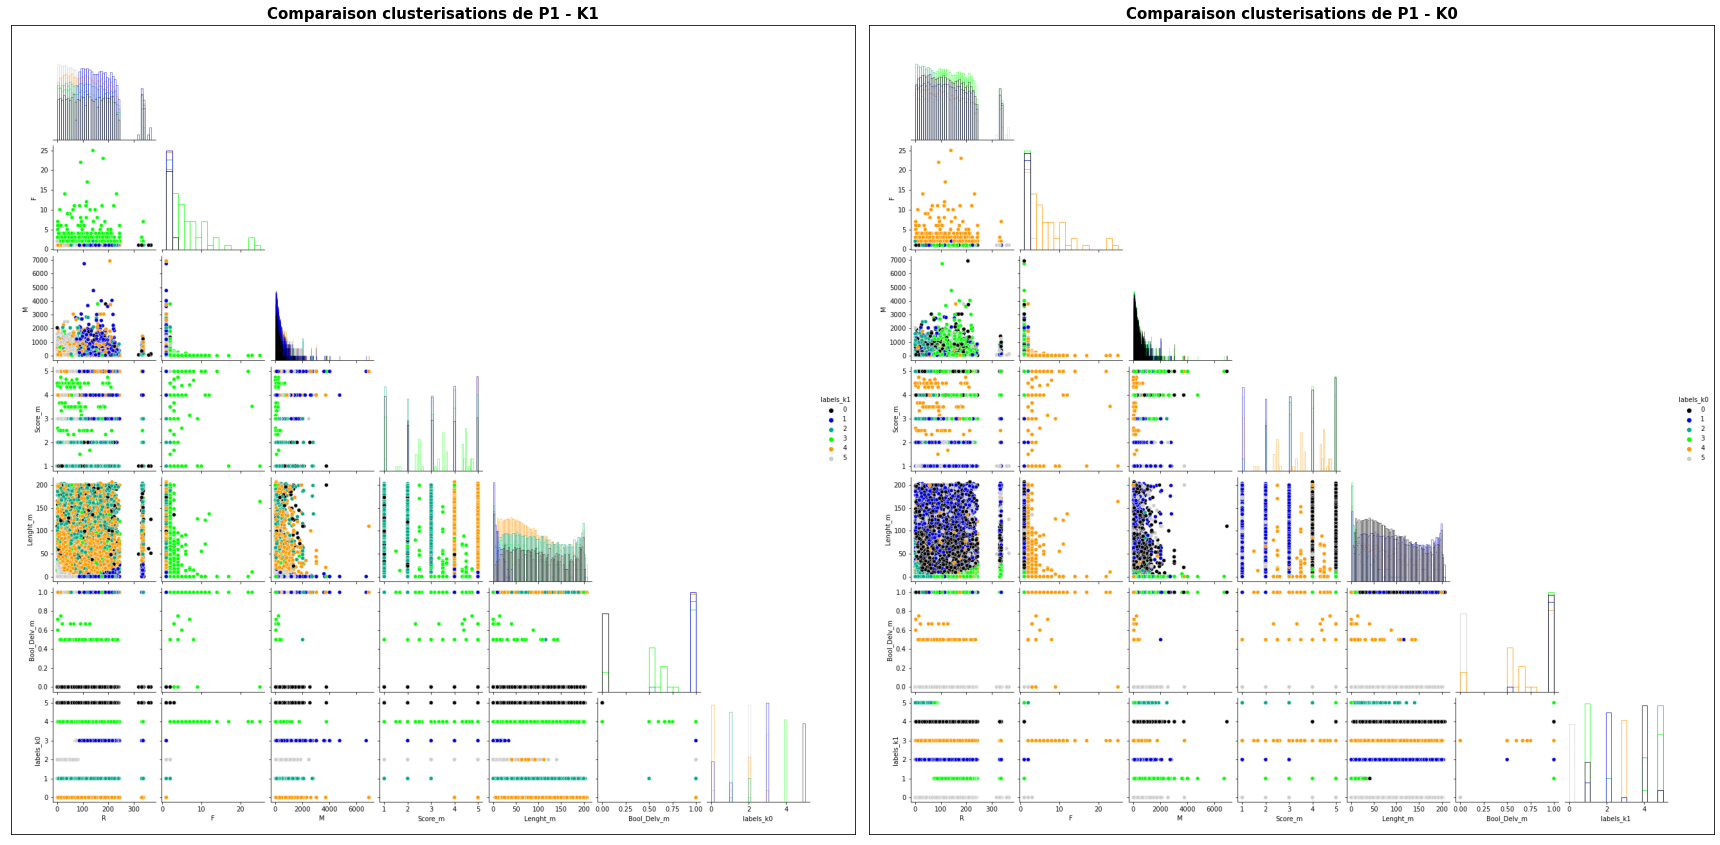

In [24]:
titre = "Comparaison clusterisations de P1"
plt.figure(titre, figsize=(24, 12)), plt.clf()
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)
### 1st Plot showing the clusters formed from K1
sns.pairplot(
    df_p1,
    corner=True,
    diag_kws={"log_scale": (False, True), "fill": False},
    diag_kind="hist",
    hue="labels_k1",
    palette="nipy_spectral",
)
plt.savefig(abs_path_fig + "curent_pairplot.png"), plt.close()
ax1.imshow(plt.imread(abs_path_fig + "curent_pairplot.png")), ax1.set_yticks(
    ticks=[]
), ax1.set_xticks(ticks=[])
ax1.set_title(titre + " - K1", fontdict={"fontsize": 15, "fontweight": "bold"})
### 2nd Plot showing the clusters formed from K0
sns.pairplot(
    df_p1,
    corner=True,
    diag_kws={"log_scale": (False, True), "fill": False},
    diag_kind="hist",
    hue="labels_k0",
    palette="nipy_spectral",
)
plt.savefig(abs_path_fig + "curent_pairplot.png"), plt.close()
ax2.imshow(plt.imread(abs_path_fig + "curent_pairplot.png")), ax2.set_yticks(
    ticks=[]
), ax2.set_xticks(ticks=[])
ax2.set_title(titre + " - K0", fontdict={"fontsize": 15, "fontweight": "bold"})
### On ressere les deux sous figures
plt.tight_layout()
del ax1, ax2

## 
## <b><u>IV.1) Calcul effectif :</u></b>
### On peut donc déployer nos fonctions non plus seulement sur 1 seule semaine supplémentaire, mais sur 52 :

In [25]:
# Initialisation de la liste où seront rangés les scores ARI
tab_ariscore = [1.0]
# Nbr de semaines sur lesquelles on fait le calcul
nb_semaines = 52
# Tableau des période Pn, définie comme Pn = P0 - n * T
tab_pn = np.array([[t0, t0 + duree_0 + n * delta_t] for n in np.arange(1, nb_semaines)])
ti = datetime.now()
for n, pn in enumerate(tab_pn):
    prediction_k0, prediction_kn = predict_from_k0vsfit_predict_from_kn(
        df_input_n=df_b2d_rfm,
        p_temp_n=pn,
        tab_pipeline_0=tab_pipeline_p0,
        tab_pipeline_n=[
            make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)
        ],
        k_0=kmeans_p0,
        k_n=KMeans(n_clusters=kmeans_p0.get_params()["n_clusters"], random_state=rgn),
    )
    tab_ariscore.append(ari_score(labels_true=prediction_kn, labels_pred=prediction_k0))
    del prediction_kn, prediction_k0
tab_ariscore = np.array(tab_ariscore)
tf = datetime.now()
print(
    f"Au total, calcul de tous les ARIscores accompli en {(tf-ti).seconds : >3.0f} secondes (soit {(tf-ti).seconds/60 : >3.1f} minutes)."
)
del ti, tf

Au total, calcul de tous les ARIscores accompli en  92 secondes (soit 1.5 minutes).


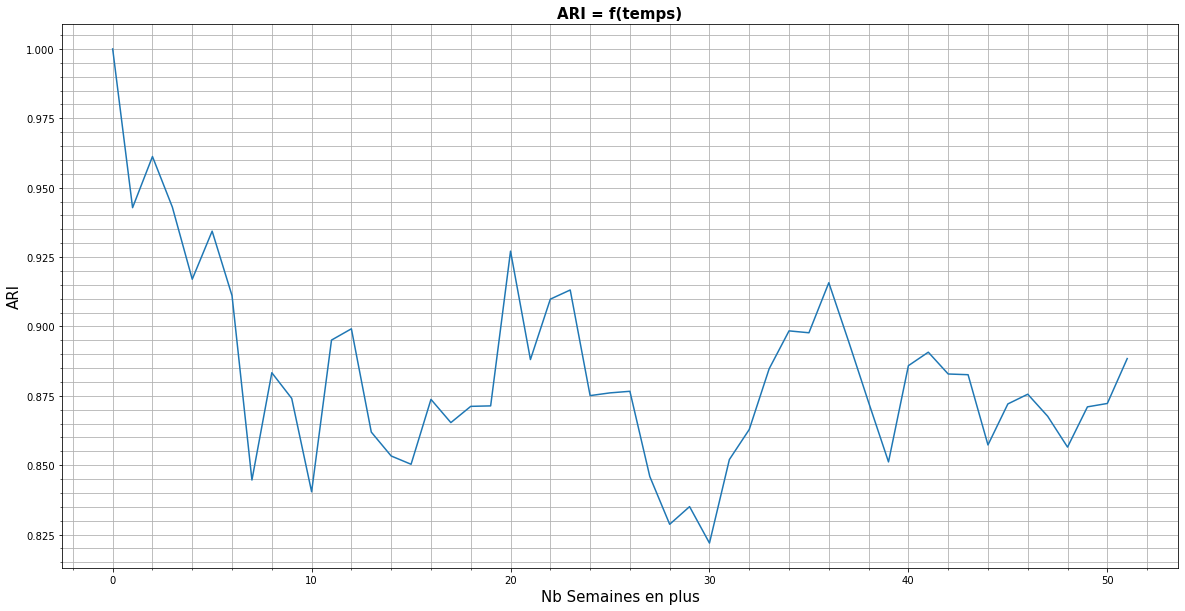

In [26]:
plt.figure("ARI = f(temps)", figsize=(20, 10)), plt.clf()
axe = plt.subplot(1, 1, 1)
plt.grid(which="both", axis="both")
plt.minorticks_on()
axe.set_title(
    "ARI = f(temps)", fontdict={"fontsize": 15, "fontweight": "bold"}
), axe.set_ylabel(f"ARI", fontsize=15), axe.set_xlabel(f"Date", fontsize=15)
axe.plot([n for n in np.arange(0, nb_semaines)], tab_ariscore), axe.set_xlabel(
    f"Nb Semaines en plus", fontsize=15
)
if sauvegarde_figure:
    plt.savefig(prefixe_titre_fig + "ARI_f(t)_12W" + ".png")

### L'ARI décroît un peu pendant deux mois, mais ensuite se stabilite entre 0.8 et 0.9 pendant un an. Nos clusters sont remarquablement stables.

# 
# <b><u>V) Calculs d'ARI sur la fenêtre maximale :</u></b>
### Comme on est presque arrivé sur la date maximale permise par le jeu de donnée, on décide de prendre le problème à l'envers :
### On va prendre P0 = les deux années permises par la base de donnée originale, et on chaque nouvelle fenêtre temporelle aura une semaine EN MOINS.
### Pour résumer, P0 2 Ans, et delta_T = - 1 semaine.
### Cela aura en plus le mérite de nous rapprocher de la méthode employée sur le notebbok précédent, où les clients qui servaient à érpouver les différentes méthodes de segmentation étaient pris sur les deux années.
### Notons qyue grâce à la fonction groupby(), on n'a même plus besoin de faire une sélectin aléatoire de nos clients sur deux années, car nos calculs sont beaucoup plus rapides, donc on peut leur soumettre beaucoup plus de données d'entraînement.

### Bien, on reprend les étapes précédentes :
### 1) On calcule nos 6 features de segmentation RFM augmentée sur deux ans.

In [27]:
### On redéfinit la fenêtre temporelle P0 comme égale à la fenêtre de 
### durée maximale permise par la base de donnée
t0_tot, tf_tot = (
    df_b2d_rfm["order_purchase_timestamp"].min(),
    df_b2d_rfm["order_purchase_timestamp"].max(),
)
duree_0_tot = tf_tot - t0_tot
p0_tot = [t0, tf_tot]
# On construit un Dataframe correspondant à P0
df_p0_tot = groupby_seg_rfm_6feat(df_b2d_rfm, p0_tot)
# Affichage de contrôle
df_p0_tot

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
861eff4711a542e4b93843c6dd7febb0,519,1,146.87,4.0,0.0,1.0
290c77bc529b7ac935b93aa66c333dc3,277,1,335.48,5.0,0.0,1.0
060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73,5.0,0.0,1.0
259dac757896d24d7702b9acbbff3f3c,218,1,173.30,5.0,0.0,1.0
345ecd01c38d18a9036ed96c73b8d066,80,1,252.25,5.0,45.0,1.0
...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,193,1,88.78,4.0,0.0,1.0
d52a67c98be1cf6a5c84435bd38d095d,196,1,129.06,5.0,0.0,1.0
e9f50caf99f032f0bf3c55141f019d99,191,1,56.04,1.0,68.0,1.0
73c2643a0a458b49f58cea58833b192e,347,1,711.07,5.0,0.0,1.0


In [28]:
df_p0_tot.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
count,95371.000000,95371.000000,95371.000000,95371.000000,95371.000000,95371.000000
mean,287.571778,1.073953,158.462541,4.085150,28.437845,0.971612
std,153.410573,0.391632,218.254869,1.341814,48.263248,0.164629
min,0.000000,1.000000,1.937895,1.000000,0.000000,0.000000
1%,57.000000,1.000000,20.380000,1.000000,0.000000,0.000000
5%,71.000000,1.000000,31.320000,1.000000,0.000000,1.000000
10%,90.000000,1.000000,38.190000,1.000000,0.000000,1.000000
25%,163.000000,1.000000,60.750000,4.000000,0.000000,1.000000
50%,268.000000,1.000000,103.680000,5.000000,0.000000,1.000000
75%,397.000000,1.000000,174.960000,5.000000,42.000000,1.000000


### On refait le scaling habituel sur P0 pour égaliser les écarts-types de ces features

In [29]:
df_p0_tot_scaled, tab_pipeline_p0_tot = scaling_6feat(
    df_p0_tot,
    "fit_transform",
    [make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)],
)
# Affichage
df_p0_scaled

,R,F,M,Score_m,Lenght_m,Bool_Delv_m
861eff4711a542e4b93843c6dd7febb0,0.203379,-0.227539,0.476072,-0.098560,-0.828691,0.21371
e607ede0e63436308660236f5a52da5e,-1.212751,-0.227539,0.252311,0.670206,-0.828691,0.21371
4390ddbb6276a66ff1736a6710205dca,0.574595,-0.227539,-0.066541,0.670206,0.712639,0.21371
2e6a42a9b5cbb0da62988694f18ee295,0.220058,-0.227539,-0.952295,-0.867325,-0.828691,0.21371
e079b18794454de9d2be5c12b4392294,-0.172731,2.940516,0.957151,0.670206,0.538013,0.21371
...,...,...,...,...,...,...
1c137fe37df712015f6488edafe8ece4,1.851734,-0.227539,-0.558392,-2.404857,1.035076,0.21371
206e64e8af2633a2ebe158a7fcb860db,0.220058,-0.227539,0.018820,-2.404857,-0.828691,0.21371
874c93d867b18eb09a5e2f071ee89458,0.764710,-0.227539,0.332629,-0.098560,-0.828691,0.21371
277490f0d435b602fe4475d4b89e9181,0.090452,-0.227539,0.018820,0.670206,-0.828691,0.21371


### On re-entraîne un KMeans à 6 clusters sur ce nouveau P0 de deux ans.

In [30]:
kmeans_p0_tot = KMeans(n_clusters=6, random_state=rgn)
kmeans_p0_tot.fit(df_p0_tot_scaled)

KMeans(n_clusters=6, random_state=420)

### On recommence à faire des prédictions comparatives entre K0 et KN sur des fenêtre temporelles PN = P0 - n semaines, le tout sur 80 semaines d'affilée :

In [31]:
# Initialisation de la liste où seront rangés les scores ARI
tab_ariscore_tot = [1.0]
# Nbr de semaines sur lesquelles on fait le calcul
nb_semaines_tot = 80
# Tableau des période Pn, définie comme Pn = P0 - n * T
tab_pn_tot = np.array(
    [[t0_tot, tf_tot - n * delta_t] for n in np.arange(1, nb_semaines_tot)]
)
ti = datetime.now()
for n, pn in enumerate(tab_pn_tot):
    prediction_k0, prediction_kn = predict_from_k0vsfit_predict_from_kn(
        df_input_n=df_b2d_rfm,
        p_temp_n=pn,
        tab_pipeline_0=tab_pipeline_p0_tot,
        tab_pipeline_n=[
            make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)
        ],
        k_0=kmeans_p0_tot,
        k_n=KMeans(
            n_clusters=kmeans_p0_tot.get_params()["n_clusters"], random_state=rgn
        ),
    )
    tab_ariscore_tot.append(
        ari_score(labels_true=prediction_kn, labels_pred=prediction_k0)
    )
    del prediction_kn, prediction_k0
tab_ariscore_tot = np.array(tab_ariscore_tot)
tf = datetime.now()
print(
    f"Au total, calcul de tous les ARIscores accompli en {(tf-ti).seconds : >3.0f} secondes (soit {(tf-ti).seconds/60 : >3.1f} minutes)."
)
del ti, tf

Au total, calcul de tous les ARIscores accompli en 122 secondes (soit 2.0 minutes).


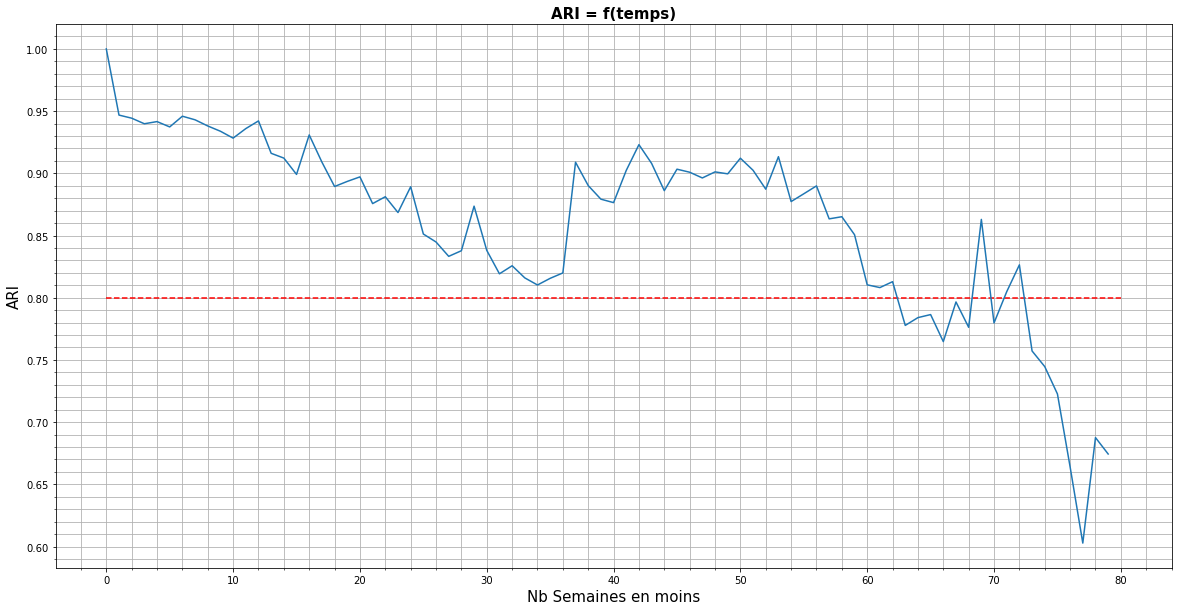

In [32]:
plt.figure("ARI = f(temps) sur 2 ans", figsize=(20, 10)), plt.clf()
axe = plt.subplot(1, 1, 1)
plt.grid(which="both", axis="both")
plt.minorticks_on()
axe.set_title(
    "ARI = f(temps)", fontdict={"fontsize": 15, "fontweight": "bold"}
), axe.set_ylabel(f"ARI", fontsize=15), axe.set_xlabel(f"Date", fontsize=15)
axe.hlines(0.8, 0, nb_semaines_tot, "red", "--")
axe.plot([n for n in np.arange(0, nb_semaines_tot)], tab_ariscore_tot), axe.set_xlabel(
    f"Nb Semaines en moins", fontsize=15
)
if sauvegarde_figure:
    plt.savefig(prefixe_titre_fig + "ARI_f(t)_2Ans_100W" + ".png")

### La stabilité précédente est retrouvée, et on finit par chuter sous ARI = 0.8 au bout de 62-73 semaines.
### Plaçons nous à P7 = 2 ans - 77 semaines, où l'ARI est le plus bas calculé jusqu'ici. Comparons les clusters prédits par K77 (entraîné sur P77) et K0 :

In [33]:
df_p77 = groupby_seg_rfm_6feat(
    df_input=df_b2d_rfm, p_temp=[t0_tot, tf_tot - 77 * delta_t]
)
tab_pipeline_p77 = [make_pipeline(tab_fonct_trans[i], tab_scaler[i]) for i in range(6)]
df_p77_scaled, tab_pipeline_p77_fitee = scaling_6feat(
    df_input=df_p77, operation="fit_transform", tab_pipeline=tab_pipeline_p77
)
k_p77 = KMeans(n_clusters=kmeans_p0_tot.get_params()["n_clusters"], random_state=rgn)
labels_p77_k77 = k_p77.fit_predict(df_p77_scaled)
df_p77_scaled_k0 = scaling_6feat(
    df_input=df_p77, operation="transform", tab_pipeline=tab_pipeline_p0
)
labels_p77_k0 = kmeans_p0.predict(df_p77_scaled_k0)

In [34]:
df_p77["labels_k77"] = labels_p77_k77
df_p77["labels_k0"] = labels_p77_k0
df_p77_describe_k77 = (
    df_p77.drop(columns=["labels_k0"]).groupby("labels_k77").describe()
)
df_p77_describe_k77[
    np.concatenate(
        (
            [("R", "count")],
            [(col, "mean") for col in df_p77_describe_k77.columns.levels[0]],
        )
    )
].sort_values(by=("R", "count"))

R                    F           M   Score_m   Lenght_m  \
             count       mean      mean        mean      mean       mean   
labels_k77                                                                 
0            135.0   0.000000  1.029630  142.308222  4.062963  24.829630   
2            388.0  50.814433  2.453608   92.039007  4.133862  26.829897   
3            426.0  73.187793  1.025822  227.944988  1.739437  66.607981   
4            994.0  54.718310  1.001006  170.210473  1.667002  80.190141   
1           1917.0  55.883672  1.000000  184.391440  4.782994  58.003652   
5           3559.0  48.866255  1.000000  158.266940  4.537230   0.107614   

           Bool_Delv_m  
                  mean  
labels_k77              
0             0.985185  
2             0.974227  
3             0.000000  
4             1.000000  
1             1.000000  
5             1.000000

In [35]:
df_p77_describe_k0 = df_p77.drop(columns=["labels_k77"]).groupby("labels_k0").describe()
df_p77_describe_k0[
    np.concatenate(
        (
            [("R", "count")],
            [(col, "mean") for col in df_p77_describe_k0.columns.levels[0]],
        )
    )
].sort_values(by=("R", "count"))

R                    F           M   Score_m   Lenght_m  \
            count       mean      mean        mean      mean       mean   
labels_k0                                                                 
4           392.0  50.313776  2.448980   97.098316  4.126118  27.313776   
5           427.0  73.016393  1.025761  228.288396  1.737705  66.669789   
1           935.0  55.188235  1.000000  171.309754  1.629947  84.771123   
2          1730.0  17.228902  1.000578  152.834575  4.452601   2.757803   
0          1772.0  56.146727  1.000000  187.724786  4.784989  61.726862   
3          2163.0  71.441516  1.000000  159.592469  4.531669   0.386038   

          Bool_Delv_m  
                 mean  
labels_k0              
4            0.974490  
5            0.000000  
1            1.000000  
2            0.999422  
0            1.000000  
3            1.000000

### On retrouve 4 clusters prédits K77 qui ont leurs jumeaux prédits par K0 (respectivement : les clusters n°2,3,4 et 1 prédits par K77, et les clusters n°4,5,1 et 0 prédits par K0), d'où un ARI qui demeure malgré tout au dessus de 0.5.
### Les différences (clusters prédits par K77 non prédits par K0 et réciproquement) démarrent avec des changement d'ordre de grandeurs de valeurs prises par la récence (0 pour le cluster 0 de K77 et 17 pour le cluster 2 de K0, par exemple). C'est après tout logique, car en modifiant la fenêtre temporelle, on modifie nécessairement la récence des élément communs aux deux fenêtre P0 et PN (en tout cas pour ceux présents une seule fois... ce qui est le cas de 97% des clients...).